In [1]:
# Import Libraries 
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
from patsy import dmatrices
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()
import statsmodels.formula.api as sm

<Figure size 720x540 with 0 Axes>

In [2]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(y):
    return pd.Series([y.count(), y.isnull().sum(), y.sum(), y.mean(), y.median(),  y.std(), y.var(), y.min(), y.dropna().quantile(0.01), y.dropna().quantile(0.05),y.dropna().quantile(0.10),y.dropna().quantile(0.25),y.dropna().quantile(0.50),y.dropna().quantile(0.75), y.dropna().quantile(0.90),y.dropna().quantile(0.95), y.dropna().quantile(0.99),y.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

def summary(x):
    num_var=[key for key in dict(x.dtypes) if dict(x.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
    y=x[num_var]
    summary=y.apply(lambda z: var_summary(z)).T
    return summary

In [3]:
# An utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [4]:
def datedata(df,col):
    df['year'] = df[col].dt.year
    df['month'] = df[col].dt.month
    df['day'] = df[col].dt.day
    df.rename(columns={'year':col+'_year','month':col+'_month','day':col+'_day'},inplace=True)
    df.drop(col,axis=1,inplace=True)
    return df

In [5]:
#Handling Outliers 
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

def outlier(x):
    num_var=[key for key in dict(x.dtypes) if dict(x.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
    all_var=[key for key in dict(x.dtypes)]
    cat_var=list(set(all_var)-set(num_var))
    y=x[num_var]
    z=x[cat_var]
    y=y.apply(lambda o: outlier_capping(o))
    x=pd.concat([y,z],axis=1)
    return x

In [6]:
def replace_category(df,col,cat1,cat2):
    a=df[col][df[col]==cat1].count()
    b=df[col][df[col]==cat2].count()
    c=df[col].shape[0]
    count_cat1=int((a/(a+b))*c)
    count_cat2=c-count_cat1
    fill_a=count_cat1-a
    fill_b=count_cat2-b
    z=find_index_(df,fill_a,col)
    df[col][1:z].fillna(cat1,inplace=True)
    df[col][z:-1].fillna(cat2,inplace=True)
    return df    

In [7]:
def replace_category3(df,col,cat1,cat2,cat3):
    a=df[col][df[col]==cat1].count()
    b=df[col][df[col]==cat2].count()
    c=df[col][df[col]==cat3].count()
    d=df[col].shape[0]
    count_cat1=int((a/(a+b+c))*d)
    count_cat2=int(b/(a+b+c)*d)
    count_cat3=d-count_cat1-count_cat2
    fill_a=count_cat1-a
    fill_b=count_cat2-b
    fill_c=count_cat3-c
    z=find_index_(df,fill_a,col)
    y= find_index_(df,fill_a+fill_b,col)
    df[col][1:z].fillna(cat1,inplace=True)
    df[col][z:y].fillna(cat2,inplace=True)
    df[col][y:-1].fillna(cat3,inplace=True)
    return df   

In [8]:
def replace_category6(df,col,cat1,cat2,cat3,cat4,cat5,cat6):
    a=df[col][df[col]==cat1].count()
    b=df[col][df[col]==cat2].count()
    c=df[col][df[col]==cat3].count()
    d=df[col][df[col]==cat4].count()
    e=df[col][df[col]==cat5].count()
    f=df[col][df[col]==cat6].count()
    g=df[col].shape[0]
    count_cat1=int((a/(a+b+c+d+e+f))*g)
    count_cat2=int((b/(a+b+c+d+e+f))*g)
    count_cat3=int((c/(a+b+c+d+e+f))*g)
    count_cat4=int((d/(a+b+c+d+e+f))*g)
    count_cat5=int((e/(a+b+c+d+e+f))*g)
    count_cat6=g-(count_cat1+count_cat2+count_cat3+count_cat4+count_cat5)
    fill_a=count_cat1-a
    fill_b=count_cat2-b
    fill_c=count_cat3-c
    fill_d=count_cat1-d
    fill_e=count_cat2-e
    fill_f=count_cat3-f
    z= find_index_(df,fill_a,col)
    y= find_index_(df,(fill_a+fill_b),col)
    x= find_index_(df,(fill_a+fill_b+fill_c),col)
    w= find_index_(df,(fill_a+fill_b+fill_c+fill_d),col)
    v= find_index_(df,(fill_a+fill_b+fill_c+fill_d+fill_e),col)
    df[col][1:z].fillna(cat1,inplace=True)
    df[col][z:y].fillna(cat2,inplace=True)
    df[col][y:x].fillna(cat3,inplace=True)
    df[col][x:w].fillna(cat4,inplace=True)
    df[col][w:v].fillna(cat5,inplace=True)
    df[col][v:-1].fillna(cat6,inplace=True)
    return df

In [9]:
def replace_category7(df,col,cat1,cat2,cat3,cat4,cat5,cat6,cat7):
    a=df[col][df[col]==cat1].count()
    b=df[col][df[col]==cat2].count()
    c=df[col][df[col]==cat3].count()
    d=df[col][df[col]==cat4].count()
    e=df[col][df[col]==cat5].count()
    f=df[col][df[col]==cat6].count()
    g=df[col][df[col]==cat7].count()
    h=df[col].shape[0]
    count_cat1=int((a/(a+b+c+d+e+f+g))*h)
    count_cat2=int((b/(a+b+c+d+e+f+g))*h)
    count_cat3=int((c/(a+b+c+d+e+f+g))*h)
    count_cat4=int((d/(a+b+c+d+e+f+g))*h)
    count_cat5=int((e/(a+b+c+d+e+f+g))*h)
    count_cat6=int((f/(a+b+c+d+e+f+g))*h)
    count_cat7=h-(count_cat1+count_cat2+count_cat3+count_cat4+count_cat5+count_cat6)
    fill_a=count_cat1-a
    fill_b=count_cat2-b
    fill_c=count_cat3-c
    fill_d=count_cat1-d
    fill_e=count_cat2-e
    fill_f=count_cat3-f
    fill_g=count_cat3-g
    z= find_index_(df,fill_a,col)
    y= find_index_(df,(fill_a+fill_b),col)
    x= find_index_(df,(fill_a+fill_b+fill_c),col)
    w= find_index_(df,(fill_a+fill_b+fill_c+fill_d),col)
    v= find_index_(df,(fill_a+fill_b+fill_c+fill_d+fill_e),col)
    u= find_index_(df,(fill_a+fill_b+fill_c+fill_d+fill_e+fill_f),col)
    df[col][1:z].fillna(cat1,inplace=True)
    df[col][z:y].fillna(cat2,inplace=True)
    df[col][y:x].fillna(cat3,inplace=True)
    df[col][x:w].fillna(cat4,inplace=True)
    df[col][w:v].fillna(cat5,inplace=True)
    df[col][v:u].fillna(cat6,inplace=True)
    df[col][u:-1].fillna(cat7,inplace=True)
    return df   

In [10]:
def find_index_(df,to_find,col):
    min_=1
    max_=len(data)
    to_find=to_find
    while(min_<max_):
        mid=int((min_+max_)/2)
#         print("Mid is"+str(mid))
#         print()
        if((df[1:mid][col].isna().sum()==to_find)and((df[col][(mid-1):mid].isna()).values)):
#             print(str(df[1:mid][col].isna().sum())+"=="+str(to_find))
#             print()
            return mid
        elif((df[1:mid][col].isna().sum()>to_find)or(df[1:mid][col].isna().sum()==to_find)):
            max_=mid-1
#             print(df[1:mid][col].isna().sum())
#             print("Max is"+str(max_))
#             print("Mid is"+str(mid))
#             print("Min is"+str(min_))
#             print()
        else:
            min_=mid+1
#             print(df[1:mid][col].isna().sum())
#             print("Max is"+str(max_))
#             print("Mid is"+str(mid))
#             print("Min is"+str(min_))
#             print()
        if(max_==min_):
            if((df[1:min_][col].isna().sum()==to_find)and((df[col][(min_-1):min_].isna()).values)):
                return min_
#                 print(str(df[1:min_][col].isna().sum())+"=="+str(to_find))
#                 print() 

In [11]:
# Import Data 
data_active=pd.read_excel('5. TELECOM CASE STUDY - SEGMENTATION-CLASSIFICATION//Case_study_data.xlsx',sheet_name=0)
data_churn=pd.read_excel('5. TELECOM CASE STUDY - SEGMENTATION-CLASSIFICATION//Case_study_data.xlsx',sheet_name='Churn Customers')

In [12]:
data_active.head()

,SITE_ACCOUNT_NUMBER,ACCOUNT_STATUS,FIRST_COMMUNICATION_DATE,UPGRADE_DATE,SERVICE_ PLAN,MODEL,SALES_CHANNEL,DIRECT_INDIRECT_CHANNEL,SALES_SOURCE,COMPANY_SOURCE_NAME,...,SITE_TYPE_DESC,WARRANTY_NAME,MOST_RECENT_SALES_CHANNEL,GENDER,DATE_OF_BIRTH,AGE,INCOME,MARITAL_STATUS,PRESENCE_OF_CHILDREN,COMPUTER_OWNER
0,AMR-11112345,Active,2001-11-27,2003-12-14,NaN,HN9000,Vars,Indirect,UNKNOWN,HNS Customers,...,Broadband Remote,0,HN7000 Upgrade,2.0,1-5-1943,69,0,1.0,0.0,N
1,AMR-14837287,Active,2003-05-02,2006-08-08,Pro,HN7000S,Sales Agents,Indirect,NCC,HNS Customers,...,Spaceway,0,Retail,2.0,28-12-1969,43,4,1.0,0.0,N
2,AMR-14837803,Active,2001-01-28,2004-03-17,Power150,HN9000,Call Center,Indirect,NCC,HNS Customers,...,Broadband Remote,0,National Sales,2.0,20-7-1954,58,4,1.0,0.0,N
3,AMR-14837821,Active,2001-11-20,2005-03-27,Power150,DW6000,Sales Agents,Direct,NaN,HNS Customers,...,Spaceway,0,Direct,NaN,10-5-1990,22,6,1.0,1.0,NaN
4,AMR-14839297,Active,2002-02-27,2004-06-14,Home,HN7000S,Call Center,Indirect,TAG,HNS Customers,...,Broadband Remote,0,DW6000 Upgrade,1.0,11-5-1976,36,7,0.0,0.0,NaN


In [13]:
data_churn.head()

,SITE_ACCOUNT_NUMBER,ACCOUNT_STATUS,FIRST_COMMUNICATION_DATE,CHURN_DATE,UPGRADE_DATE,SERVICE_PLAN,MODEL,SALES_CHANNEL,DIRECT_INDIRECT_CHANNEL,SALES_SOURCE,...,SITE_TYPE_DESC,WARRANTY_NAME,MOST_RECENT_SALES_CHANNEL,GENDER,DATE_OF_BIRTH,AGE,INCOME,MARITAL_STATUS,PRESENCE_OF_CHILDREN,COMPUTER_OWNER
0,AMR-53205840,Closed,2002-01-18,2006-04-02,2004-01-03,Professional,DW6000,NaN,Indirect,Perfect 10,...,Broadband Remote,NaN,Dealer-Generated Sale,2.0,27-10-1964,48.0,0,.,NaN,N
1,AMR-53383136,Closed,2002-01-02,2006-07-09,2004-07-28,SO,DW6000,Retail/Others,Indirect,ValueElectronics,...,Broadband Remote,NaN,National Sales,NaN,22-10-1965,47.0,5,0,0.0,Y
2,AMR-53608585,Closed,2002-01-06,2008-12-30,2005-04-27,NaN,DW6000,Retail/Others,Indirect,TAG,...,Broadband Remote,NaN,Direct,2.0,20-3-1951,61.0,8,1,0.0,Y
3,AMR-53610590,Closed,2002-01-05,2004-08-19,NaT,SO,DW4000,NaN,Indirect,TAG,...,Broadband Remote,NaN,Direct,1.0,27-3-1948,64.0,0,.,NaN,Y
4,AMR-53612154,Closed,2002-01-05,2006-08-17,2005-11-12,Professional,DW7000,Retail/Others,Indirect,Perfect 10,...,Broadband Remote,NaN,Dealer-Generated Sale,1.0,25-8-1956,56.0,6,0,0.0,N


In [14]:
# Lastest/last date in the Data at Which churn was noticed 
data_churn.CHURN_DATE.max()

Timestamp('2012-07-25 00:00:00')

In [15]:
# 'DAYS_ACTIVE' is the number of Days a account was active.'DAYS_ACTIVE'= Churn Date - First Cummunication Date 
data_churn['DAYS_ACTIVE']=data_churn['CHURN_DATE']-data_churn['FIRST_COMMUNICATION_DATE']

In [16]:
data_churn.head()

,SITE_ACCOUNT_NUMBER,ACCOUNT_STATUS,FIRST_COMMUNICATION_DATE,CHURN_DATE,UPGRADE_DATE,SERVICE_PLAN,MODEL,SALES_CHANNEL,DIRECT_INDIRECT_CHANNEL,SALES_SOURCE,...,WARRANTY_NAME,MOST_RECENT_SALES_CHANNEL,GENDER,DATE_OF_BIRTH,AGE,INCOME,MARITAL_STATUS,PRESENCE_OF_CHILDREN,COMPUTER_OWNER,DAYS_ACTIVE
0,AMR-53205840,Closed,2002-01-18,2006-04-02,2004-01-03,Professional,DW6000,NaN,Indirect,Perfect 10,...,NaN,Dealer-Generated Sale,2.0,27-10-1964,48.0,0,.,NaN,N,1535 days
1,AMR-53383136,Closed,2002-01-02,2006-07-09,2004-07-28,SO,DW6000,Retail/Others,Indirect,ValueElectronics,...,NaN,National Sales,NaN,22-10-1965,47.0,5,0,0.0,Y,1649 days
2,AMR-53608585,Closed,2002-01-06,2008-12-30,2005-04-27,NaN,DW6000,Retail/Others,Indirect,TAG,...,NaN,Direct,2.0,20-3-1951,61.0,8,1,0.0,Y,2550 days
3,AMR-53610590,Closed,2002-01-05,2004-08-19,NaT,SO,DW4000,NaN,Indirect,TAG,...,NaN,Direct,1.0,27-3-1948,64.0,0,.,NaN,Y,957 days
4,AMR-53612154,Closed,2002-01-05,2006-08-17,2005-11-12,Professional,DW7000,Retail/Others,Indirect,Perfect 10,...,NaN,Dealer-Generated Sale,1.0,25-8-1956,56.0,6,0,0.0,N,1685 days


In [17]:
# 'DAYS_ACTIVE' is the number of Days a account was active.'DAYS_ACTIVE'= Last Churn DAte - First Cummunication Date 
# Here we don't have Churn Date so we use Latest/Last Churn Date as Reference 
data_active['DAYS_ACTIVE']=data_churn.CHURN_DATE.max()-data_active['FIRST_COMMUNICATION_DATE']

In [18]:
# Dropping the Column 'CHURN_DATE' to concatenate the two datasets "data_churn" and "data_active" because "CHURN_DATE" is only present in churn dataset
data_churn.drop('CHURN_DATE',axis=1,inplace=True)

In [19]:
data_churn.head()

,SITE_ACCOUNT_NUMBER,ACCOUNT_STATUS,FIRST_COMMUNICATION_DATE,UPGRADE_DATE,SERVICE_PLAN,MODEL,SALES_CHANNEL,DIRECT_INDIRECT_CHANNEL,SALES_SOURCE,COMPANY_SOURCE_NAME,...,WARRANTY_NAME,MOST_RECENT_SALES_CHANNEL,GENDER,DATE_OF_BIRTH,AGE,INCOME,MARITAL_STATUS,PRESENCE_OF_CHILDREN,COMPUTER_OWNER,DAYS_ACTIVE
0,AMR-53205840,Closed,2002-01-18,2004-01-03,Professional,DW6000,NaN,Indirect,Perfect 10,HNS Customers,...,NaN,Dealer-Generated Sale,2.0,27-10-1964,48.0,0,.,NaN,N,1535 days
1,AMR-53383136,Closed,2002-01-02,2004-07-28,SO,DW6000,Retail/Others,Indirect,ValueElectronics,HNS Customers,...,NaN,National Sales,NaN,22-10-1965,47.0,5,0,0.0,Y,1649 days
2,AMR-53608585,Closed,2002-01-06,2005-04-27,NaN,DW6000,Retail/Others,Indirect,TAG,HNS Customers,...,NaN,Direct,2.0,20-3-1951,61.0,8,1,0.0,Y,2550 days
3,AMR-53610590,Closed,2002-01-05,NaT,SO,DW4000,NaN,Indirect,TAG,HNS Customers,...,NaN,Direct,1.0,27-3-1948,64.0,0,.,NaN,Y,957 days
4,AMR-53612154,Closed,2002-01-05,2005-11-12,Professional,DW7000,Retail/Others,Indirect,Perfect 10,HNS Customers,...,NaN,Dealer-Generated Sale,1.0,25-8-1956,56.0,6,0,0.0,N,1685 days


In [20]:
data_churn.columns   # Checking Columns of "data_churn" DataFrame before merging the two DataFrame 

Index(['SITE_ACCOUNT_NUMBER', 'ACCOUNT_STATUS', 'FIRST_COMMUNICATION_DATE',
       'UPGRADE_DATE', 'SERVICE_PLAN', 'MODEL', 'SALES_CHANNEL',
       'DIRECT_INDIRECT_CHANNEL', 'SALES_SOURCE', 'COMPANY_SOURCE_NAME',
       'FIRST_NAME', 'LAST_NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIPCODE',
       'EMAIL_ADDRESS', 'FEEDBACK', 'SATELLITE', 'SITE_TYPE_DESC',
       'WARRANTY_NAME', 'MOST_RECENT_SALES_CHANNEL', 'GENDER', 'DATE_OF_BIRTH',
       'AGE', 'INCOME', 'MARITAL_STATUS', 'PRESENCE_OF_CHILDREN',
       'COMPUTER_OWNER', 'DAYS_ACTIVE'],
      dtype='object')

In [21]:
data_active.columns   # Checking Columns of "data_active" DataFrame before merging the two DataFrame 

Index(['SITE_ACCOUNT_NUMBER', 'ACCOUNT_STATUS', 'FIRST_COMMUNICATION_DATE',
       'UPGRADE_DATE', 'SERVICE_ PLAN', 'MODEL', 'SALES_CHANNEL',
       'DIRECT_INDIRECT_CHANNEL', 'SALES_SOURCE', 'COMPANY_SOURCE_NAME',
       'FIRST_NAME', 'LAST_NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIPCODE',
       'EMAIL_ADDRESS', 'FEEDBACK', 'SATELLITE', 'SITE_TYPE_DESC',
       'WARRANTY_NAME', 'MOST_RECENT_SALES_CHANNEL', 'GENDER', 'DATE_OF_BIRTH',
       'AGE', 'INCOME', 'MARITAL_STATUS', 'PRESENCE_OF_CHILDREN',
       'COMPUTER_OWNER', 'DAYS_ACTIVE'],
      dtype='object')

In [22]:
 # Renaming Column 'SERVICE_ PLAN' to 'SERVICE_PLAN' so that column name is same in both columns  
data_active.rename(columns={'SERVICE_ PLAN':'SERVICE_PLAN'},inplace=True)

In [23]:
data_active.set_index('SITE_ACCOUNT_NUMBER',inplace=True) # Setting 'SITE_ACCOUNT_NUMBER' as index to concatenate/stacking 
data_churn.set_index('SITE_ACCOUNT_NUMBER',inplace=True) # Setting 'SITE_ACCOUNT_NUMBER' as index to concatenate/stacking 
data=pd.concat([data_active,data_churn],axis=0) # Concatenating/stacking  both the DataFrame to Combine to form one Dataframe 

In [24]:
data.info() # Checking the New DataFrame 

<class 'pandas.core.frame.DataFrame'>
Index: 19999 entries, AMR-11112345 to T000080092
Data columns (total 29 columns):
ACCOUNT_STATUS               19983 non-null object
FIRST_COMMUNICATION_DATE     19989 non-null datetime64[ns]
UPGRADE_DATE                 19110 non-null datetime64[ns]
SERVICE_PLAN                 17278 non-null object
MODEL                        18613 non-null object
SALES_CHANNEL                14491 non-null object
DIRECT_INDIRECT_CHANNEL      19170 non-null object
SALES_SOURCE                 19016 non-null object
COMPANY_SOURCE_NAME          19980 non-null object
FIRST_NAME                   19972 non-null object
LAST_NAME                    19991 non-null object
ADDRESS                      19936 non-null object
CITY                         19998 non-null object
STATE                        19932 non-null object
ZIPCODE                      19932 non-null object
EMAIL_ADDRESS                19959 non-null object
FEEDBACK                     16057 non-null obje

### Handling Missing Values and Dropping Columns 

In [25]:
## Dropping columns beacuse they have high Cardinality/Unique Values 
data.drop(['COMPANY_SOURCE_NAME','FIRST_NAME','LAST_NAME','ADDRESS','EMAIL_ADDRESS','ZIPCODE','DATE_OF_BIRTH','SALES_SOURCE','CITY'],axis=1,inplace=True)

In [26]:
# Replacing "Active" and "Inactive" Account Status by 0 and 1 and Thus Creating "Y" Variable 
data.ACCOUNT_STATUS.replace({'Active':0,'Closed':1,'Inactive':0},inplace=True)

In [27]:
# Replacing Similiar Category Names to Make them One Category 
data.SALES_CHANNEL.replace({'Retail/Others':'Retail/others','Web Orders':'Web orders'},inplace=True) 

In [28]:
data.MOST_RECENT_SALES_CHANNEL.replace({'HN7000 Upgrade':'HN7000_Upgrade_','DW6000 Upgrade':'DW6000_Upgrade_','DPC Classic upgrade':'DPC Classic_upgrade_','HN9000 Upgrade':'HN9000_Upgrade_','DW7000 Upgrade':'DW7000_Upgrade_','Dial Return Upgrade':'Dial Return_Upgrade_',},inplace=True)

In [29]:
# Getting Date Data for the Datetime Columns 
datedata(data,'FIRST_COMMUNICATION_DATE')
datedata(data,'UPGRADE_DATE')

,ACCOUNT_STATUS,SERVICE_PLAN,MODEL,SALES_CHANNEL,DIRECT_INDIRECT_CHANNEL,STATE,FEEDBACK,SATELLITE,SITE_TYPE_DESC,WARRANTY_NAME,...,MARITAL_STATUS,PRESENCE_OF_CHILDREN,COMPUTER_OWNER,DAYS_ACTIVE,FIRST_COMMUNICATION_DATE_year,FIRST_COMMUNICATION_DATE_month,FIRST_COMMUNICATION_DATE_day,UPGRADE_DATE_year,UPGRADE_DATE_month,UPGRADE_DATE_day
SITE_ACCOUNT_NUMBER,,,,,,,,,,,,,,,,,,,,,
AMR-11112345,0.0,NaN,HN9000,Vars,Indirect,MD,NaN,SPACEWAY3,Broadband Remote,0,...,1,0.0,N,3893 days,2001.0,11.0,27.0,2003.0,12.0,14.0
AMR-14837287,0.0,Pro,HN7000S,Sales Agents,Indirect,NJ,GOOD,HZN2-VER-4K,Spaceway,0,...,1,0.0,N,3372 days,2003.0,5.0,2.0,2006.0,8.0,8.0
AMR-14837803,0.0,Power150,HN9000,Call Center,Indirect,LA,BAD,SM5-VER-15K,Broadband Remote,0,...,1,0.0,N,4196 days,2001.0,1.0,28.0,2004.0,3.0,17.0
AMR-14837821,0.0,Power150,DW6000,Sales Agents,Direct,OH,NaN,SPACEWAY3,Spaceway,0,...,1,1.0,NaN,3900 days,2001.0,11.0,20.0,2005.0,3.0,27.0
AMR-14839297,0.0,Home,HN7000S,Call Center,Indirect,NY,GOOD,0,Broadband Remote,0,...,0,0.0,NaN,3801 days,2002.0,2.0,27.0,2004.0,6.0,14.0
AMR-14840229,0.0,Pro,HN9000,Sales Agents,Indirect,TX,GOOD,SPACEWAY3,Broadband Remote,0,...,1,0.0,NaN,3823 days,2002.0,2.0,5.0,2005.0,7.0,13.0
AMR-14841940,0.0,Power150,HN7000S,NaN,Indirect,MO,NaN,G17-HOR-2K,Broadband Remote,0,...,1,0.0,NaN,3899 days,2001.0,11.0,21.0,2003.0,6.0,5.0
AMR-14842501,0.0,Power150,HN7000S,Vars,Indirect,MD,GOOD,SM5-VER-5K,Broadband Remote,0,...,0,NaN,Y,4023 days,2001.0,7.0,20.0,2004.0,1.0,25.0
AMR-14847927,0.0,Home,DW6000,Vars,Indirect,AR,GOOD,AM6-HOR-21K,Broadband Remote,0,...,2,0.0,NaN,3756 days,2002.0,4.0,13.0,2006.0,2.0,23.0


In [30]:
## Getting Date values from "DAYS_ACTIVE" column 
data.DAYS_ACTIVE=data.DAYS_ACTIVE.apply(lambda x: x.days)

In [31]:

# data['SERVICE_PLAN']=data['SERVICE_PLAN'].fillna(data['SERVICE_PLAN'].mode()[0])
# data['AGE']=data['AGE'].fillna(data['AGE'].mode()[0])
# data['INCOME']=data['INCOME'].fillna(data['INCOME'].mode()[0])
# data['MOST_RECENT_SALES_CHANNEL']=data['MOST_RECENT_SALES_CHANNEL'].fillna(data['MOST_RECENT_SALES_CHANNEL'].mode()[0])
# data['WARRANTY_NAME']=data['WARRANTY_NAME'].fillna(data['WARRANTY_NAME'].mode()[0]) 
# data['SATELLITE']=data['SATELLITE'].fillna(data['SATELLITE'].mode()[0]) 
# data['STATE']=data['STATE'].fillna(data['STATE'].mode()[0])

In [32]:
# Filling all the Categorical Variable With "Mode" which have less number of Missing Values 
fill_mode=['SERVICE_PLAN','AGE','INCOME','MOST_RECENT_SALES_CHANNEL','WARRANTY_NAME','SATELLITE','STATE','FIRST_COMMUNICATION_DATE_year','FIRST_COMMUNICATION_DATE_month','FIRST_COMMUNICATION_DATE_day','DAYS_ACTIVE','UPGRADE_DATE_month','UPGRADE_DATE_year','UPGRADE_DATE_day','FEEDBACK']
for var  in fill_mode:
    data[var]=data[var].fillna(data[var].mode()[0])

In [33]:
# Filling all the Categorical Variable with High Number of Missing Values by "replace_category" function so that Ratio between Categories is Maintained 
replace_category(data,'ACCOUNT_STATUS',1,0)
replace_category(data,'GENDER',1,2)
replace_category(data,'PRESENCE_OF_CHILDREN',1,2)
replace_category(data,'FEEDBACK','GOOD','BAD')
replace_category(data,'COMPUTER_OWNER','Y','N')
replace_category3(data,'MARITAL_STATUS',0,1,2)
replace_category3(data,'DIRECT_INDIRECT_CHANNEL',0,'Direct','Indirect')
replace_category(data,'SITE_TYPE_DESC','Broadband Remote','Spaceway')
replace_category6(data,'SALES_CHANNEL','Retail/others','Sales Agents','Web orders','Vars','Call Centers','Call Center')
replace_category7(data,'MODEL','HN7000S','HN9000','DW4000','DW6000','DW7000','UNK','DW4020')

,ACCOUNT_STATUS,SERVICE_PLAN,MODEL,SALES_CHANNEL,DIRECT_INDIRECT_CHANNEL,STATE,FEEDBACK,SATELLITE,SITE_TYPE_DESC,WARRANTY_NAME,...,MARITAL_STATUS,PRESENCE_OF_CHILDREN,COMPUTER_OWNER,DAYS_ACTIVE,FIRST_COMMUNICATION_DATE_year,FIRST_COMMUNICATION_DATE_month,FIRST_COMMUNICATION_DATE_day,UPGRADE_DATE_year,UPGRADE_DATE_month,UPGRADE_DATE_day
SITE_ACCOUNT_NUMBER,,,,,,,,,,,,,,,,,,,,,
AMR-11112345,0.0,Elite,HN9000,Vars,Indirect,MD,BAD,SPACEWAY3,Broadband Remote,0,...,1,0.0,N,3893.0,2001.0,11.0,27.0,2003.0,12.0,14.0
AMR-14837287,0.0,Pro,HN7000S,Sales Agents,Indirect,NJ,GOOD,HZN2-VER-4K,Spaceway,0,...,1,0.0,N,3372.0,2003.0,5.0,2.0,2006.0,8.0,8.0
AMR-14837803,0.0,Power150,HN9000,Call Center,Indirect,LA,BAD,SM5-VER-15K,Broadband Remote,0,...,1,0.0,N,4196.0,2001.0,1.0,28.0,2004.0,3.0,17.0
AMR-14837821,0.0,Power150,DW6000,Sales Agents,Direct,OH,BAD,SPACEWAY3,Spaceway,0,...,1,1.0,Y,3900.0,2001.0,11.0,20.0,2005.0,3.0,27.0
AMR-14839297,0.0,Home,HN7000S,Call Center,Indirect,NY,GOOD,0,Broadband Remote,0,...,0,0.0,Y,3801.0,2002.0,2.0,27.0,2004.0,6.0,14.0
AMR-14840229,0.0,Pro,HN9000,Sales Agents,Indirect,TX,GOOD,SPACEWAY3,Broadband Remote,0,...,1,0.0,Y,3823.0,2002.0,2.0,5.0,2005.0,7.0,13.0
AMR-14841940,0.0,Power150,HN7000S,Retail/others,Indirect,MO,BAD,G17-HOR-2K,Broadband Remote,0,...,1,0.0,Y,3899.0,2001.0,11.0,21.0,2003.0,6.0,5.0
AMR-14842501,0.0,Power150,HN7000S,Vars,Indirect,MD,GOOD,SM5-VER-5K,Broadband Remote,0,...,0,1.0,Y,4023.0,2001.0,7.0,20.0,2004.0,1.0,25.0
AMR-14847927,0.0,Home,DW6000,Vars,Indirect,AR,GOOD,AM6-HOR-21K,Broadband Remote,0,...,2,0.0,Y,3756.0,2002.0,4.0,13.0,2006.0,2.0,23.0


In [34]:
## "AGE" column has some values as "." which were not changed in fillna() so just filling them with mode  
data.AGE=data.AGE.replace(to_replace='.', value=data['AGE'].mode()[0])

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19999 entries, AMR-11112345 to T000080092
Data columns (total 24 columns):
ACCOUNT_STATUS                    19999 non-null float64
SERVICE_PLAN                      19999 non-null object
MODEL                             19999 non-null object
SALES_CHANNEL                     19999 non-null object
DIRECT_INDIRECT_CHANNEL           19999 non-null object
STATE                             19999 non-null object
FEEDBACK                          19999 non-null object
SATELLITE                         19999 non-null object
SITE_TYPE_DESC                    19999 non-null object
WARRANTY_NAME                     19999 non-null object
MOST_RECENT_SALES_CHANNEL         19999 non-null object
GENDER                            19999 non-null float64
AGE                               19999 non-null float64
INCOME                            19999 non-null object
MARITAL_STATUS                    19999 non-null object
PRESENCE_OF_CHILDREN              199

### Getting Dummies For Categorical Columns 

In [36]:
## Creating a list of for which dummy is to be made 
dummy=['SERVICE_PLAN','MODEL','SALES_CHANNEL','DIRECT_INDIRECT_CHANNEL','STATE','FEEDBACK','SATELLITE','SITE_TYPE_DESC','WARRANTY_NAME','MOST_RECENT_SALES_CHANNEL','GENDER','INCOME','MARITAL_STATUS','PRESENCE_OF_CHILDREN','COMPUTER_OWNER']
for c_feature in dummy:
    data[c_feature] = data[c_feature].astype('category')
    data = create_dummies(data,c_feature )

In [37]:
data.head()

,ACCOUNT_STATUS,AGE,DAYS_ACTIVE,FIRST_COMMUNICATION_DATE_year,FIRST_COMMUNICATION_DATE_month,FIRST_COMMUNICATION_DATE_day,UPGRADE_DATE_year,UPGRADE_DATE_month,UPGRADE_DATE_day,SERVICE_PLAN_Basic_Ltd,...,INCOME_9,INCOME_A,INCOME_B,INCOME_C,INCOME_D,MARITAL_STATUS_1.0,MARITAL_STATUS_2.0,MARITAL_STATUS_.,PRESENCE_OF_CHILDREN_1.0,COMPUTER_OWNER_Y
SITE_ACCOUNT_NUMBER,,,,,,,,,,,,,,,,,,,,,
AMR-11112345,0.0,69.0,3893.0,2001.0,11.0,27.0,2003.0,12.0,14.0,0,...,0,0,0,0,0,1,0,0,0,0
AMR-14837287,0.0,43.0,3372.0,2003.0,5.0,2.0,2006.0,8.0,8.0,0,...,0,0,0,0,0,1,0,0,0,0
AMR-14837803,0.0,58.0,4196.0,2001.0,1.0,28.0,2004.0,3.0,17.0,0,...,0,0,0,0,0,1,0,0,0,0
AMR-14837821,0.0,22.0,3900.0,2001.0,11.0,20.0,2005.0,3.0,27.0,0,...,0,0,0,0,0,1,0,0,1,1
AMR-14839297,0.0,36.0,3801.0,2002.0,2.0,27.0,2004.0,6.0,14.0,0,...,0,0,0,0,0,0,0,0,0,1


### Using Random Forest to do Feature Selection 

In [38]:
#Splitting the data for Random Forest to do variable Seletion 

feature_columns = data.columns.difference( ['ACCOUNT_STATUS'] )

In [39]:
from sklearn.cross_validation import train_test_split
# Splitting the Training and testig data 
train_X, test_X, train_y, test_y = train_test_split( data[feature_columns],
                                                  data['ACCOUNT_STATUS'],
                                                  test_size = 0.2,
                                                  random_state = 42 )

C:\Users\raghu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [40]:
# Building the Random Forest Classifier and fitting the model on the data 
radm_clf = RandomForestClassifier(oob_score=True,n_estimators=100 )
radm_clf.fit( train_X, train_y )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [41]:
# Prediting with Random Forest 
radm_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': radm_clf.predict( test_X ) } )

In [42]:
# Getting accuracy from Random Forest 
from sklearn import metrics
metrics.accuracy_score( radm_test_pred.actual, radm_test_pred.predicted )

0.99875

Text(0.5,15,'Predicted label')

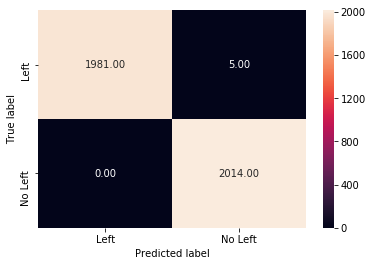

In [43]:
# Getting Confusion matrix and plotting it. 
tree_cm = metrics.confusion_matrix( radm_test_pred.predicted,
                                 radm_test_pred.actual,
                                 [1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')


In [44]:
# Getting indices for FEature Importance 
indices = np.argsort(radm_clf.feature_importances_)[::-1]

In [45]:
# Getting feature importance DataFrame  
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
 
for f in range(train_X.shape[1]):
    feature_rank.loc[f] = [f+1,
                          train_X.columns[indices[f]],
                          radm_clf.feature_importances_[indices[f]]]

# Use the down code to Plot feature Importance but not here because feature number is very Large
# sn.barplot( y = 'feature', x = 'importance', data = feature_rank )

In [131]:
# FEature importnce is not good wrt to what we got earlier 
feature_rank.head(25)

,rank,feature,importance
0,1,DAYS_ACTIVE,0.380227
1,2,FIRST_COMMUNICATION_DATE_year,0.156515
2,3,UPGRADE_DATE_year,0.144753
3,4,MOST_RECENT_SALES_CHANNEL_Hughes Sales Agents,0.056348
4,5,MARITAL_STATUS_.,0.045626
5,6,SALES_CHANNEL_Call Centers,0.027242
6,7,SITE_TYPE_DESC_Spaceway,0.021658
7,8,WARRANTY_NAME_EXPRESS REPAIR BASIC,0.021596
8,9,MOST_RECENT_SALES_CHANNEL_Direct,0.012728
9,10,MODEL_HN7000S,0.012582


In [132]:
# Cummulative sum of Feature Importance 
for i in range(1,25):
    print(str(i)+str("  ")+str(feature_rank.importance[0:i].sum()*100))

1  38.02265360667412
2  53.67411012577169
3  68.14941517769766
4  73.78420909281587
5  78.346803680173
6  81.07096934661
7  83.23677618914368
8  85.39634859350787
9  86.6691709447708
10  87.92734986807554
11  89.16096712727878
12  90.13533443224698
13  90.89294160425348
14  91.41742091857907
15  91.8258226161563
16  92.22945675041596
17  92.60766044716489
18  92.96895287473464
19  93.32136851271092
20  93.66714609137262
21  94.00840542879294
22  94.34828093229758
23  94.68328469198237
24  94.99056131938069


In [133]:
# Adding Feature Importance variable to list 
var_log = []
for i in range(0,25):
    var_log.append(feature_rank.feature[i])

### Subsetting Final Dataset

In [189]:
# Sebsetting The selected variables to New DataFrame 
data_select_logistic=data[var_log]

In [190]:
data_select_logistic.head()

,DAYS_ACTIVE,FIRST_COMMUNICATION_DATE_year,UPGRADE_DATE_year,MOST_RECENT_SALES_CHANNEL_Hughes Sales Agents,MARITAL_STATUS_.,SALES_CHANNEL_Call Centers,SITE_TYPE_DESC_Spaceway,WARRANTY_NAME_EXPRESS REPAIR BASIC,MOST_RECENT_SALES_CHANNEL_Direct,MODEL_HN7000S,...,SATELLITE_SM6-HOR-10K,SATELLITE_G3C-VER-24K,SERVICE_PLAN_Professional,MOST_RECENT_SALES_CHANNEL_Retail,SERVICE_PLAN_Power15,AGE,MODEL_DW7000,MOST_RECENT_SALES_CHANNEL_Dealer - Direct Order,FEEDBACK_GOOD,MODEL_UNK
SITE_ACCOUNT_NUMBER,,,,,,,,,,,,,,,,,,,,,
AMR-11112345,3893.0,2001.0,2003.0,0,0,0,0,0,0,0,...,0,0,0,0,0,69.0,0,0,0,0
AMR-14837287,3372.0,2003.0,2006.0,0,0,0,1,0,0,1,...,0,0,0,1,0,43.0,0,0,1,0
AMR-14837803,4196.0,2001.0,2004.0,0,0,0,0,0,0,0,...,0,0,0,0,0,58.0,0,0,0,0
AMR-14837821,3900.0,2001.0,2005.0,0,0,0,1,0,1,0,...,0,0,0,0,0,22.0,0,0,0,0
AMR-14839297,3801.0,2002.0,2004.0,0,0,0,0,0,0,1,...,0,0,0,0,0,36.0,0,0,1,0


In [191]:
# Renaming Column because without it, Calculation of VIF shos Error 
data_select_logistic.rename(columns={'MARITAL_STATUS_.':'MARITAL_STATUS_'},inplace=True)

C:\Users\raghu\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [192]:
# Adding Column Names to a list 
vare_1=[]
for var in data_select_logistic.columns:
    vare_1.append(var)

In [193]:
# Replacing " " -> Spaces with "_ " and "-" with "_" due to error in clculation of VIF
for var in range(0,25):
    vare_1[var]=vare_1[var].strip()
    vare_1[var]=vare_1[var].replace(" ","_")
    vare_1[var]=vare_1[var].replace("-","_")
vare_1   

In [195]:
# Changing Column Name of Dataset
data_select_logistic.columns=vare_1

In [196]:
data_select_logistic.head()

,DAYS_ACTIVE,FIRST_COMMUNICATION_DATE_year,UPGRADE_DATE_year,MOST_RECENT_SALES_CHANNEL_Hughes_Sales_Agents,MARITAL_STATUS_,SALES_CHANNEL_Call_Centers,SITE_TYPE_DESC_Spaceway,WARRANTY_NAME_EXPRESS_REPAIR_BASIC,MOST_RECENT_SALES_CHANNEL_Direct,MODEL_HN7000S,...,SATELLITE_SM6_HOR_10K,SATELLITE_G3C_VER_24K,SERVICE_PLAN_Professional,MOST_RECENT_SALES_CHANNEL_Retail,SERVICE_PLAN_Power15,AGE,MODEL_DW7000,MOST_RECENT_SALES_CHANNEL_Dealer___Direct_Order,FEEDBACK_GOOD,MODEL_UNK
SITE_ACCOUNT_NUMBER,,,,,,,,,,,,,,,,,,,,,
AMR-11112345,3893.0,2001.0,2003.0,0,0,0,0,0,0,0,...,0,0,0,0,0,69.0,0,0,0,0
AMR-14837287,3372.0,2003.0,2006.0,0,0,0,1,0,0,1,...,0,0,0,1,0,43.0,0,0,1,0
AMR-14837803,4196.0,2001.0,2004.0,0,0,0,0,0,0,0,...,0,0,0,0,0,58.0,0,0,0,0
AMR-14837821,3900.0,2001.0,2005.0,0,0,0,1,0,1,0,...,0,0,0,0,0,22.0,0,0,0,0
AMR-14839297,3801.0,2002.0,2004.0,0,0,0,0,0,0,1,...,0,0,0,0,0,36.0,0,0,1,0


In [197]:
# Looking at the column of the DataFrame 
data_select_logistic.columns

Index(['DAYS_ACTIVE', 'FIRST_COMMUNICATION_DATE_year', 'UPGRADE_DATE_year',
       'MOST_RECENT_SALES_CHANNEL_Hughes_Sales_Agents', 'MARITAL_STATUS_',
       'SALES_CHANNEL_Call_Centers', 'SITE_TYPE_DESC_Spaceway',
       'WARRANTY_NAME_EXPRESS_REPAIR_BASIC',
       'MOST_RECENT_SALES_CHANNEL_Direct', 'MODEL_HN7000S', 'SERVICE_PLAN_SO',
       'SERVICE_PLAN_Power150', 'MOST_RECENT_SALES_CHANNEL_HN7000_Upgrade_',
       'SATELLITE_SPACEWAY3', 'FIRST_COMMUNICATION_DATE_day',
       'SATELLITE_SM6_HOR_10K', 'SATELLITE_G3C_VER_24K',
       'SERVICE_PLAN_Professional', 'MOST_RECENT_SALES_CHANNEL_Retail',
       'SERVICE_PLAN_Power15', 'AGE', 'MODEL_DW7000',
       'MOST_RECENT_SALES_CHANNEL_Dealer___Direct_Order', 'FEEDBACK_GOOD',
       'MODEL_UNK'],
      dtype='object')

In [198]:
# Calculating VIF for selected variables for Multicollinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = pd.concat([data_select_logistic,data['ACCOUNT_STATUS']], axis=1)
features = "+".join(data_select_logistic.columns)
X.head()
a,b = dmatrices(formula_like='ACCOUNT_STATUS ~ '+ features, data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

      VIF Factor                                         features
0   1.048212e+06                                        Intercept
1   1.430318e+01                                      DAYS_ACTIVE
2   4.501123e+01                    FIRST_COMMUNICATION_DATE_year
3   3.511702e+01                                UPGRADE_DATE_year
4   1.915587e+00    MOST_RECENT_SALES_CHANNEL_Hughes_Sales_Agents
5   1.202507e+00                                  MARITAL_STATUS_
6   1.159678e+00                       SALES_CHANNEL_Call_Centers
7   1.306744e+00                          SITE_TYPE_DESC_Spaceway
8   1.144180e+00               WARRANTY_NAME_EXPRESS_REPAIR_BASIC
9   1.684892e+00                 MOST_RECENT_SALES_CHANNEL_Direct
10  1.279914e+00                                    MODEL_HN7000S
11  1.084671e+00                                  SERVICE_PLAN_SO
12  1.058487e+00                            SERVICE_PLAN_Power150
13  1.156619e+00        MOST_RECENT_SALES_CHANNEL_HN7000_Upgrade_
14  1.2020

In [199]:
# Sorting the VIF values of all variables 
vif.sort_values('VIF Factor',ascending=False)

,VIF Factor,features
0,1.048212e+06,Intercept
2,4.501123e+01,FIRST_COMMUNICATION_DATE_year
3,3.511702e+01,UPGRADE_DATE_year
1,1.430318e+01,DAYS_ACTIVE
4,1.915587e+00,MOST_RECENT_SALES_CHANNEL_Hughes_Sales_Agents
9,1.684892e+00,MOST_RECENT_SALES_CHANNEL_Direct
7,1.306744e+00,SITE_TYPE_DESC_Spaceway
10,1.279914e+00,MODEL_HN7000S
5,1.202507e+00,MARITAL_STATUS_
14,1.202032e+00,SATELLITE_SPACEWAY3


In [200]:
# Droping two Column due ti High VIF value 
data_select_logistic.drop(['FIRST_COMMUNICATION_DATE_year','DAYS_ACTIVE'],axis=1,inplace=True)

C:\Users\raghu\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [201]:
data_select_logistic.head()

,UPGRADE_DATE_year,MOST_RECENT_SALES_CHANNEL_Hughes_Sales_Agents,MARITAL_STATUS_,SALES_CHANNEL_Call_Centers,SITE_TYPE_DESC_Spaceway,WARRANTY_NAME_EXPRESS_REPAIR_BASIC,MOST_RECENT_SALES_CHANNEL_Direct,MODEL_HN7000S,SERVICE_PLAN_SO,SERVICE_PLAN_Power150,...,SATELLITE_SM6_HOR_10K,SATELLITE_G3C_VER_24K,SERVICE_PLAN_Professional,MOST_RECENT_SALES_CHANNEL_Retail,SERVICE_PLAN_Power15,AGE,MODEL_DW7000,MOST_RECENT_SALES_CHANNEL_Dealer___Direct_Order,FEEDBACK_GOOD,MODEL_UNK
SITE_ACCOUNT_NUMBER,,,,,,,,,,,,,,,,,,,,,
AMR-11112345,2003.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,69.0,0,0,0,0
AMR-14837287,2006.0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,43.0,0,0,1,0
AMR-14837803,2004.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,58.0,0,0,0,0
AMR-14837821,2005.0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,22.0,0,0,0,0
AMR-14839297,2004.0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,36.0,0,0,1,0


In [202]:
# Calculating VIF again to see all olumn have low VIF 
X = pd.concat([data_select_logistic,data['ACCOUNT_STATUS']], axis=1)
features = "+".join(data_select_logistic.columns)
X.head()

a,b = dmatrices(formula_like='ACCOUNT_STATUS ~ '+ features, data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif) # VIF is All under Control 

       VIF Factor                                         features
0   111076.485204                                        Intercept
1        1.157285                                UPGRADE_DATE_year
2        1.696897    MOST_RECENT_SALES_CHANNEL_Hughes_Sales_Agents
3        1.174546                                  MARITAL_STATUS_
4        1.143018                       SALES_CHANNEL_Call_Centers
5        1.269063                          SITE_TYPE_DESC_Spaceway
6        1.122571               WARRANTY_NAME_EXPRESS_REPAIR_BASIC
7        1.572270                 MOST_RECENT_SALES_CHANNEL_Direct
8        1.260906                                    MODEL_HN7000S
9        1.073477                                  SERVICE_PLAN_SO
10       1.051273                            SERVICE_PLAN_Power150
11       1.155786        MOST_RECENT_SALES_CHANNEL_HN7000_Upgrade_
12       1.187942                              SATELLITE_SPACEWAY3
13       1.012748                     FIRST_COMMUNICATION_DATE

In [203]:
# Sorting VIF in descending order
vif.sort_values('VIF Factor',ascending=False)

,VIF Factor,features
0,111076.485204,Intercept
2,1.696897,MOST_RECENT_SALES_CHANNEL_Hughes_Sales_Agents
7,1.572270,MOST_RECENT_SALES_CHANNEL_Direct
5,1.269063,SITE_TYPE_DESC_Spaceway
8,1.260906,MODEL_HN7000S
12,1.187942,SATELLITE_SPACEWAY3
22,1.184984,FEEDBACK_GOOD
15,1.182905,SATELLITE_G3C_VER_24K
3,1.174546,MARITAL_STATUS_
1,1.157285,UPGRADE_DATE_year


In [204]:
# Concatenating the dataframe with Y Variavle 
data_select_logistic= pd.concat([data_select_logistic,data['ACCOUNT_STATUS']], axis=1)

In [159]:
# Dropping column based on Manual Calculation
# data_select_logistic.drop(['MOST_RECENT_SALES_CHANNEL_Retail','SERVICE_PLAN_Power15','SERVICE_PLAN_Power150','MOST_RECENT_SALES_CHANNEL_HN7000_Upgrade_'],axis=1,inplace=True)

In [205]:
#Train and Test split
train_features = data_select_logistic.columns.difference(['ACCOUNT_STATUS'])
train_X, test_X = train_test_split(data_select_logistic, test_size=0.3, random_state=411)
train_X.columns

Index(['UPGRADE_DATE_year', 'MOST_RECENT_SALES_CHANNEL_Hughes_Sales_Agents',
       'MARITAL_STATUS_', 'SALES_CHANNEL_Call_Centers',
       'SITE_TYPE_DESC_Spaceway', 'WARRANTY_NAME_EXPRESS_REPAIR_BASIC',
       'MOST_RECENT_SALES_CHANNEL_Direct', 'MODEL_HN7000S', 'SERVICE_PLAN_SO',
       'SERVICE_PLAN_Power150', 'MOST_RECENT_SALES_CHANNEL_HN7000_Upgrade_',
       'SATELLITE_SPACEWAY3', 'FIRST_COMMUNICATION_DATE_day',
       'SATELLITE_SM6_HOR_10K', 'SATELLITE_G3C_VER_24K',
       'SERVICE_PLAN_Professional', 'MOST_RECENT_SALES_CHANNEL_Retail',
       'SERVICE_PLAN_Power15', 'AGE', 'MODEL_DW7000',
       'MOST_RECENT_SALES_CHANNEL_Dealer___Direct_Order', 'FEEDBACK_GOOD',
       'MODEL_UNK', 'ACCOUNT_STATUS'],
      dtype='object')

In [206]:
# Building a Logistic Model on the DataFrame and fitting the model 
logreg = sm.logit(formula='ACCOUNT_STATUS ~ ' + "+".join(train_features), data=train_X)
result = logreg.fit()
summ = result.summary()
summ

         Current function value: 0.065512
         Iterations: 35


C:\Users\raghu\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         ACCOUNT_STATUS   No. Observations:                13999
Model:                          Logit   Df Residuals:                    13975
Method:                           MLE   Df Model:                           23
Date:                Mon, 29 Oct 2018   Pseudo R-squ.:                  0.9055
Time:                        19:24:25   Log-Likelihood:                -917.10
converged:                      False   LL-Null:                       -9703.4
                                        LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                       -1488.5256     58.493    -25.448      0.000   -1603.169   -1373.882
AGE                                                 0.0219      0.005      4.768      0.000       0.013       0.031
FEEDBACK_GOOD                                      -0.7833      0.134     -5.826      0.000      -1.047      -0.520
FIRST_COMMUNICATION_DATE_day                       -0.0284      0.007     -3.866      0.000      -0.043      -0.014
MARITAL_STATUS_                                     7.3521      0.927      7.928      0.000       5.534       9.170
MODEL_DW7000                                        1.2533      0.232      5.396      0.000       0.798       1.709
MODEL_HN7000S                                      -1.3793      0.154     -8.973      0.000      -1.681      -1.078
MODEL_UNK                                          -3.4031      0.584     -5.823      0.000      -4.548      -2.258
MOST_RECENT_SALES_CHANNEL_Dealer___Direct_Order     6.6970      1.043      6.420      0.000       4.653       8.741
MOST_RECENT_SALES_CHANNEL_Direct                    2.3702      0.140     16.989      0.000       2.097       2.644
MOST_RECENT_SALES_CHANNEL_HN7000_Upgrade_          -0.3237      0.248     -1.308      0.191      -0.809       0.161
MOST_RECENT_SALES_CHANNEL_Hughes_Sales_Agents       7.1962      0.551     13.052      0.000       6.116       8.277
MOST_RECENT_SALES_CHANNEL_Retail                  -25.1664   6.21e+04     -0.000      1.000   -1.22e+05    1.22e+05
SALES_CHANNEL_Call_Centers                          5.6749      0.649      8.737      0.000       4.402       6.948
SATELLITE_G3C_VER_24K                               3.2760      0.346      9.461      0.000       2.597       3.955
SATELLITE_SM6_HOR_10K                               4.8582      0.567      8.573      0.000       3.747       5.969
SATELLITE_SPACEWAY3                                 1.2979      0.137      9.482      0.000       1.030       1.566
SERVICE_PLAN_Power15                               29.0321   5.13e+04      0.001      1.000   -1.01e+05    1.01e+05
SERVICE_PLAN_Power150                             -18.0461    965.709     -0.019      0.985   -1910.800    1874.708
SERVICE_PLAN_Professional                           5.1586      1.043      4.948      0.000       3.115       7.202
SERVICE_PLAN_SO                                     6.5892      1.134      5.812      0.000       4.367       8.811
SITE_TYPE_DESC_Spaceway                             1.5316      0.130     11.747      0.000       1.276       1.787
UPGRADE_DATE_year                                   0.7403      0.029     25.391      0.000       0.683       0.797
WARRANTY_NAME_EXPRESS_REPAIR_BASIC                  4.0028      0.337     11.888      0.000       3.343       4.663
=============================================================================================================

In [207]:
# Sorting p_values in descending order
summary_pvalue=result.pvalues.sort_values(ascending=False)
summary_pvalue

MOST_RECENT_SALES_CHANNEL_Retail                    9.996766e-01
SERVICE_PLAN_Power15                                9.995486e-01
SERVICE_PLAN_Power150                               9.850908e-01
MOST_RECENT_SALES_CHANNEL_HN7000_Upgrade_           1.909025e-01
FIRST_COMMUNICATION_DATE_day                        1.107743e-04
AGE                                                 1.857670e-06
SERVICE_PLAN_Professional                           7.514122e-07
MODEL_DW7000                                        6.827973e-08
SERVICE_PLAN_SO                                     6.161571e-09
MODEL_UNK                                           5.765515e-09
FEEDBACK_GOOD                                       5.690893e-09
MOST_RECENT_SALES_CHANNEL_Dealer___Direct_Order     1.358937e-10
MARITAL_STATUS_                                     2.234894e-15
SATELLITE_SM6_HOR_10K                               1.008464e-17
SALES_CHANNEL_Call_Centers                          2.385152e-18
MODEL_HN7000S            

In [208]:
# Taking variables which have p-value less than 0.02 -> Removing column with high p-Values 
while(summary_pvalue[0])>0.02:
    data_select_logistic.drop(summary_pvalue.index[0],axis=1,inplace=True)
    train_features = data_select_logistic.columns.difference(['ACCOUNT_STATUS'])
    train_X, test_X = train_test_split(X, test_size=0.3, random_state=411)
    logreg = sm.logit(formula='ACCOUNT_STATUS ~ ' + "+".join(train_features), data=train_X)
    result = logreg.fit()
    summary_pvalue=result.pvalues.sort_values(ascending=False)
    
    

         Current function value: 0.066727
         Iterations: 35


C:\Users\raghu\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 7.124053
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.075021
         Iterations 13


C:\Users\raghu\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.075036
         Iterations 12


In [209]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         ACCOUNT_STATUS   No. Observations:                13999
Model:                          Logit   Df Residuals:                    13979
Method:                           MLE   Df Model:                           19
Date:                Mon, 29 Oct 2018   Pseudo R-squ.:                  0.8917
Time:                        19:24:39   Log-Likelihood:                -1050.4
converged:                       True   LL-Null:                       -9703.4
                                        LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                       -1541.8602     55.727    -27.668      0.000   -1651.084   -1432.637
AGE                                                 0.0230      0.004      5.355      0.000       0.015       0.031
FEEDBACK_GOOD                                      -0.7638      0.126     -6.043      0.000      -1.012      -0.516
FIRST_COMMUNICATION_DATE_day                       -0.0268      0.007     -3.883      0.000      -0.040      -0.013
MARITAL_STATUS_                                     7.5732      0.934      8.106      0.000       5.742       9.404
MODEL_DW7000                                        1.3949      0.222      6.269      0.000       0.959       1.831
MODEL_HN7000S                                      -1.1666      0.138     -8.451      0.000      -1.437      -0.896
MODEL_UNK                                          -3.3815      0.551     -6.138      0.000      -4.461      -2.302
MOST_RECENT_SALES_CHANNEL_Dealer___Direct_Order     7.1002      1.037      6.844      0.000       5.067       9.133
MOST_RECENT_SALES_CHANNEL_Direct                    2.5092      0.125     20.132      0.000       2.265       2.753
MOST_RECENT_SALES_CHANNEL_Hughes_Sales_Agents       7.6007      0.546     13.928      0.000       6.531       8.670
SALES_CHANNEL_Call_Centers                          6.2424      0.643      9.715      0.000       4.983       7.502
SATELLITE_G3C_VER_24K                               3.3704      0.312     10.815      0.000       2.760       3.981
SATELLITE_SM6_HOR_10K                               4.6868      0.487      9.628      0.000       3.733       5.641
SATELLITE_SPACEWAY3                                 1.2758      0.128      9.964      0.000       1.025       1.527
SERVICE_PLAN_Professional                           5.1398      1.041      4.936      0.000       3.099       7.181
SERVICE_PLAN_SO                                     6.6034      1.102      5.991      0.000       4.443       8.764
SITE_TYPE_DESC_Spaceway                             1.4780      0.122     12.094      0.000       1.238       1.717
UPGRADE_DATE_year                                   0.7667      0.028     27.605      0.000       0.712       0.821
WARRANTY_NAME_EXPRESS_REPAIR_BASIC                  4.1646      0.320     13.033      0.000       3.538       4.791
===================================================================================================================

Possibly complete quasi-separation: A fraction 0.33 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [210]:
# Calculating Training and Testing Ginni score 
train_gini = 2*metrics.roc_auc_score(train_X['ACCOUNT_STATUS'], result.predict()) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X['ACCOUNT_STATUS'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.9899606122744897
The Gini Index for the model built on the Test Data is :  0.9911688879076543


In [211]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train_X))
train_predicted_prob.columns = ['prob']
train_actual = train_X['ACCOUNT_STATUS']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

,actual,prob
SITE_ACCOUNT_NUMBER,,
AMR-39302889,0.0,0.025384
AMR-91114598,1.0,0.977593
AMR-26979959,0.0,0.000950
AMR-31187808,0.0,0.010320
AMR-31466906,0.0,0.005295


In [212]:
# Getting Probabilities
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['ACCOUNT_STATUS']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

,actual,prob
SITE_ACCOUNT_NUMBER,,
AMR-31193749,0.0,0.127115
AMR-93263710,1.0,0.999927
AMR-94507761,1.0,0.999676
AMR-37871819,0.0,0.009037
AMR-21504540,0.0,0.005076


In [213]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [214]:
roc_like_df.head()

,cutoff,sensitivity,specificity
0,0.000000,1.000000,0.000000
0,0.020408,0.994994,0.710188
0,0.040816,0.991847,0.817066
0,0.061224,0.990559,0.864441
0,0.081633,0.988700,0.891267


In [215]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.591837,0.96424,0.991581,1.955821


In [219]:
cutoff=roc_like_df[roc_like_df['total']==roc_like_df['total'].max()].cutoff[0]

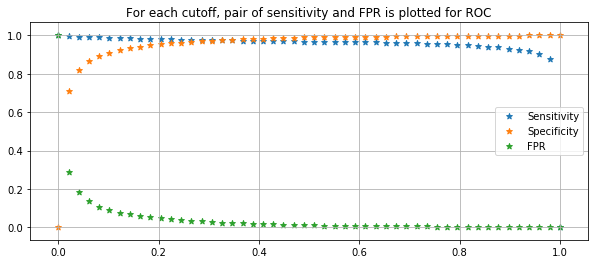

In [220]:
# Plotting specificity and Sensitivity 
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

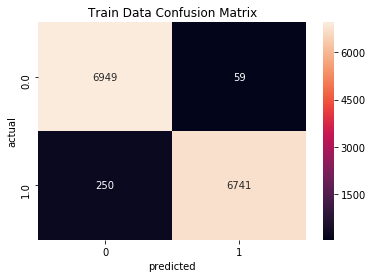

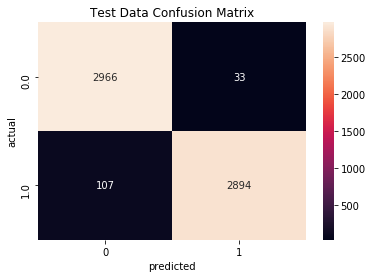

In [221]:
# Confusion Matrix when sensitivity and specificivity are maximum  
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > cutoff else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > cutoff else 0)
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()

In [222]:
# Accuracy in the training and testing data 
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.9779269947853418
The overall accuracy score for the Test Data  is :  0.9766666666666667
